# Nonlinear Buckling Method Verification

We want to verify Nastran's nonlinear buckling method on a box beam model. We consider a box beam model with a rigid tip section and a concentrated load applied at the center of such section.

## Problem definition

***

### Geometry

In [1]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


### Material

In [2]:
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

## Setup of the numerical model

***

### Mesh and boundary conditions

Simple box beam without ribs.

In [3]:
from resources import box_beam_utils

edge_length = 86  # [mm]
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=edge_length)
box_beam_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


### Load

Applied load: concentrated force applied at the center of the tip section, which is made rigid.

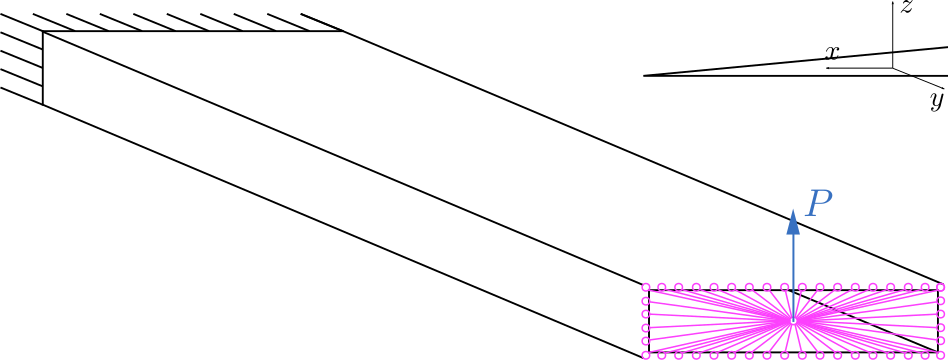

In [4]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [5]:
import numpy as np

# Add master node of tip section
master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf_input.add_grid(master_node_id, [w/2, b, 0.])
# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1]==b]
rbe2_eid = len(box_beam_bdf_input.elements) + 1
box_beam_bdf_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)
# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

FORCE         11    1761              1.      0.      0.      1.

## Nonlinear buckling method

***

Define function to set up nonlinear analysis, buckling parameters and subcases, then run the analysis and return the `OP2` object.

In [6]:
from resources import pynastran_utils
from pyNastran.op2.op2 import read_op2

def apply_nonlinear_buckling_method(bdf_input, applied_load_magnitudes, input_filename, run_flag=True):
    # Set up nonlinear analysis with arc-length method
    pynastran_utils.set_up_arc_length_method(bdf_object=bdf_input, ninc=100, max_iter=25, conv='PUV', eps_p=1e-3, eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.1, desiter=5, maxinc=1000)
    # Define parameters for buckling analysis
    bdf_input.add_param('BUCKLE', [2])
    eigrl_set_id = force_set_id+1
    bdf_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)
    bdf_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)
    # Create the LOAD cards corresponding to the input load magnitudes and the associated subcases
    for i, scale_factor in enumerate(applied_load_magnitudes):
        load_set_id = 21+i
        bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
        pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=i+1, load_set_id=load_set_id)
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=input_filename, run_flag=run_flag)
    # Read op2 file
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    # Return op2 object
    return op2

Define applied loads.

In [7]:
linear_buckling_load = 1657   # [N]
load_magnitudes = np.linspace(0, 2*linear_buckling_load, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {load_magnitudes}')

Applied loads [N]: [ 331.  663.  994. 1326. 1657. 1988. 2320. 2651. 2983. 3314.]


Run analysis.

In [8]:
# Define name of analysis directory
analysis_directory_name = '06_Nonlinear_Buckling_Method_Verification'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Run analysis
input_name = 'nonlinear_buckling_verification'
op2_output = apply_nonlinear_buckling_method(box_beam_bdf_input.__deepcopy__({}), load_magnitudes, input_name, run_flag=False)

Nastran job nonlinear_buckling_verification.bdf completed
Wall time: 97.0 s


Plot results in terms of critical buckling loads predicted by SOL 106 and critical buckling factors.

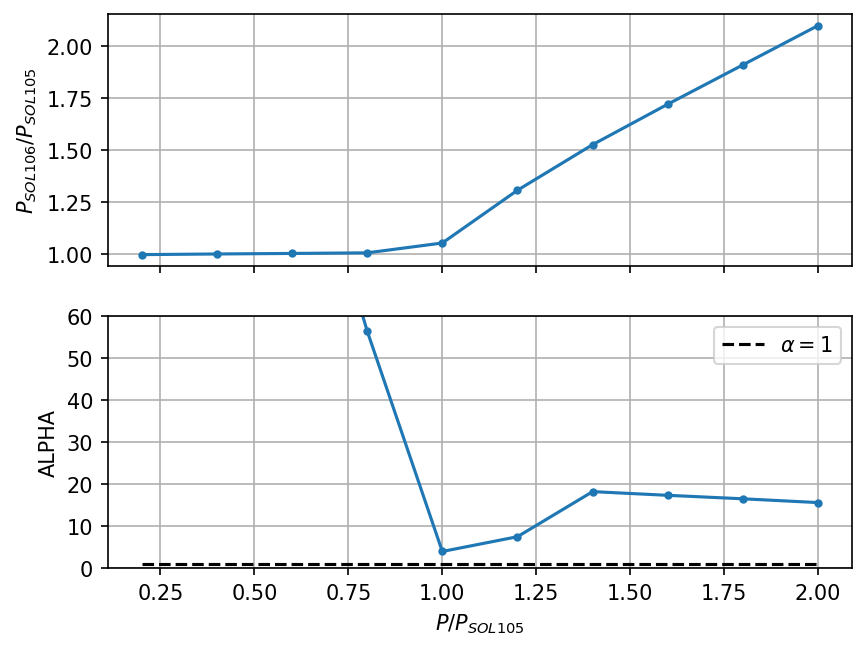

In [9]:
import matplotlib.pyplot as plt

def plot_buckling_loads(applied_loads, sol_105_buckling_load, sol_106_buckling_loads, alphas):
    # Create figure with subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex='all')
    # Plot applied loads vs buckling loads
    axs[0].plot(applied_loads/sol_105_buckling_load, sol_106_buckling_loads/sol_105_buckling_load, '.-')
    # Plot applied loads vs critical buckling factors
    axs[1].plot(applied_loads/sol_105_buckling_load, alphas, '.-')
    reference, = axs[1].plot(applied_loads/sol_105_buckling_load, [1]*len(applied_loads), '--k', label='$\\alpha=1$')
    # Set plot appearance
    axs[0].set_ylabel('$P_{SOL 106}/P_{SOL 105}$')
    axs[0].grid(visible=True)
    axs[1].set_ylabel('ALPHA')
    axs[1].grid(visible=True)
    axs[1].legend(handles=[reference])
    axs[1].set_xlabel('$P/P_{SOL 105}$')
    axs[1].set_ylim([0, 60])
    # Show plot
    plt.show()

# Set default dpi of figures
plt.rcParams['figure.dpi'] = 150
# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=op2_output)
# Plot results
plot_buckling_loads(load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)

Plot load-displacement diagram.

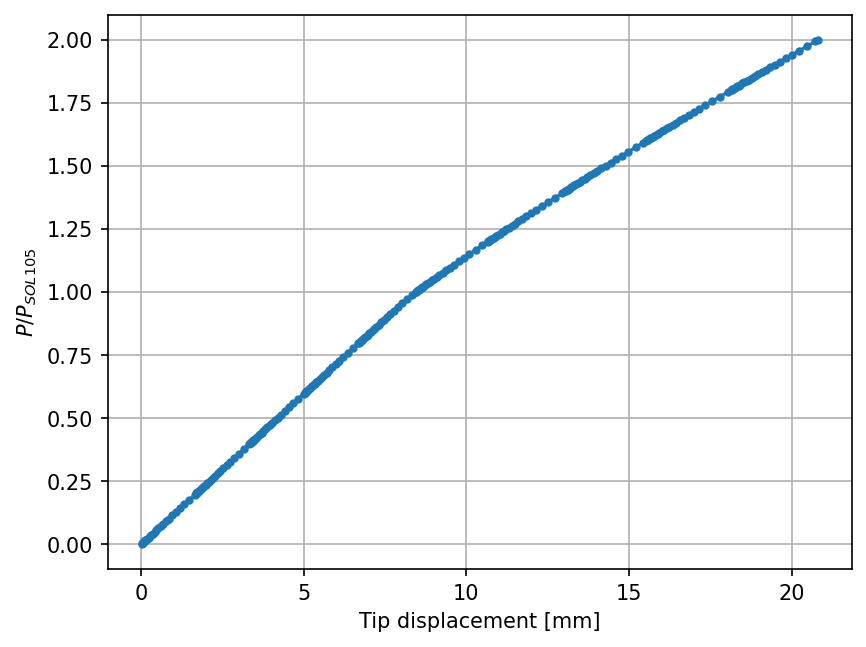

(<Figure size 960x720 with 2 Axes>,
 <Axes3DSubplot:xlabel='x [mm]', ylabel='y [mm]'>)

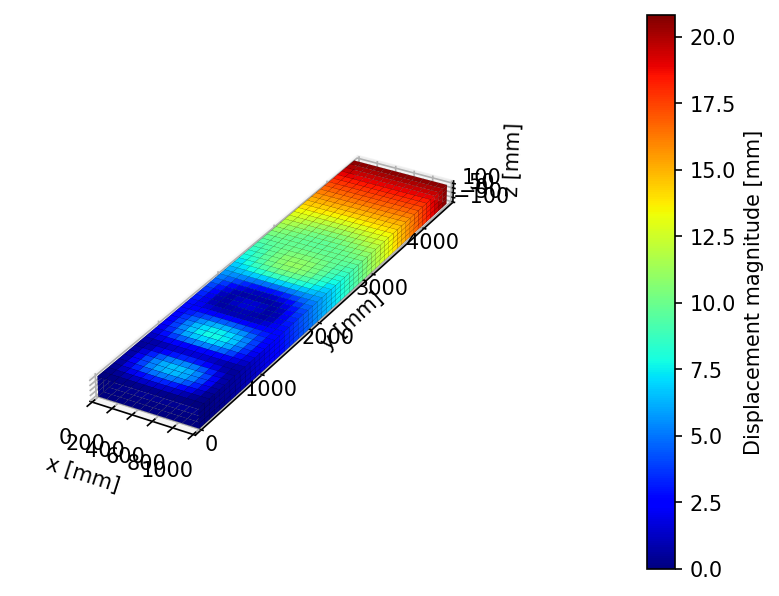

In [10]:
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2
# Collect load and displacement history
load_history = np.concatenate([loads[subcase_id][:, load_component_index] for subcase_id in displacements])
displacement_history = np.concatenate([displacements[subcase_id][:,displacement_component_index] for subcase_id in displacements])
# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacement_history, load_history/linear_buckling_load, '.-')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()
# Plot structural deformation
valid_subcase_ids = [subcase_id for subcase_id in op2_output.load_vectors if hasattr(op2_output.load_vectors[subcase_id], 'lftsfqs')]
pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=valid_subcase_ids[-1])

Let's zoom in where applied load vs buckling load curve changes slope.

In [11]:
# Define applied loads
load_magnitudes = np.linspace(.75*linear_buckling_load, 1.25*linear_buckling_load, 10)
print(f'Applied loads [N]: {load_magnitudes}')
# Run analysis
input_name = 'nonlinear_buckling_verification_zoomed'
op2_output = apply_nonlinear_buckling_method(box_beam_bdf_input.__deepcopy__({}), load_magnitudes, input_name, run_flag=False)

Applied loads [N]: [1243. 1335. 1427. 1519. 1611. 1703. 1795. 1887. 1979. 2071.]
Nastran job nonlinear_buckling_verification_zoomed.bdf completed
Wall time: 77.0 s


Plot results

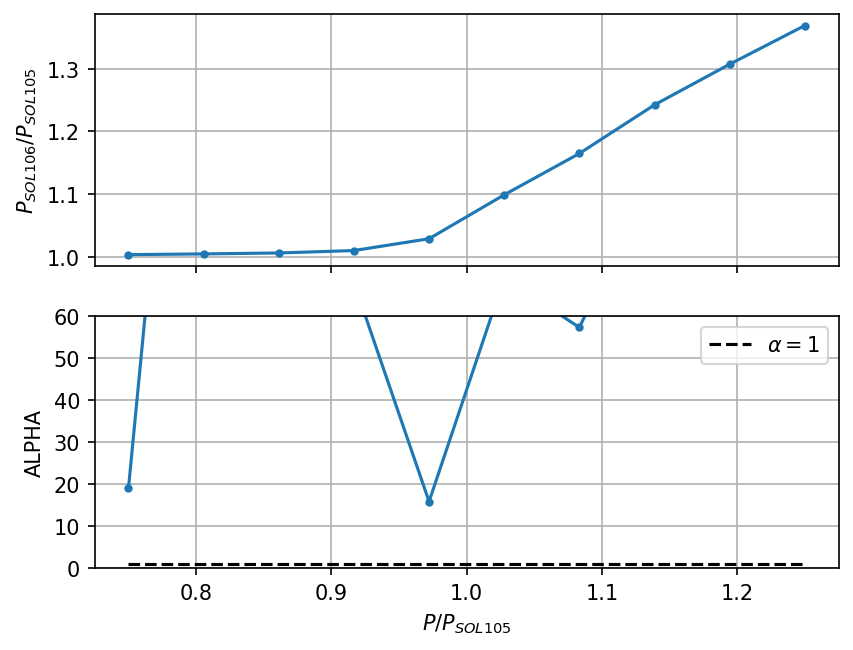

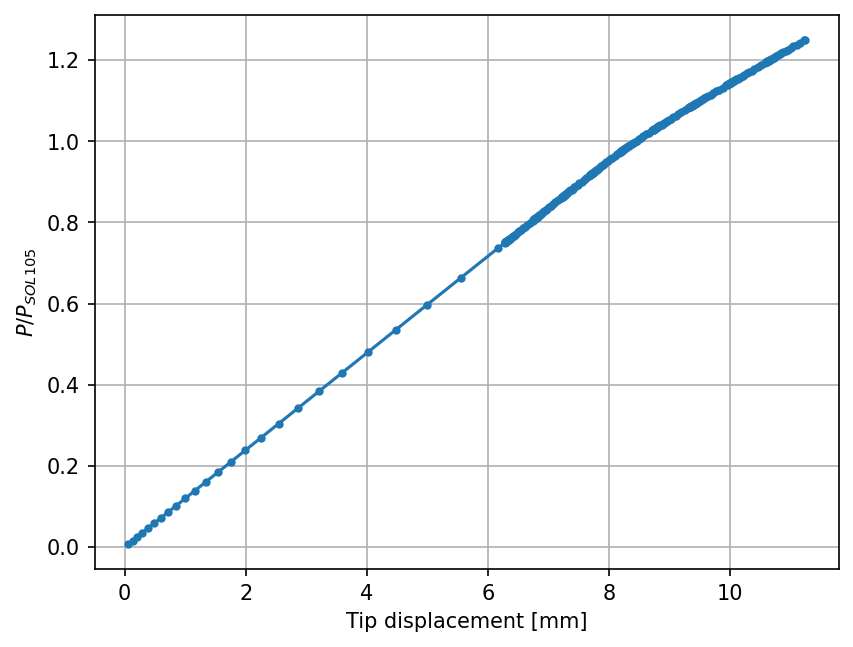

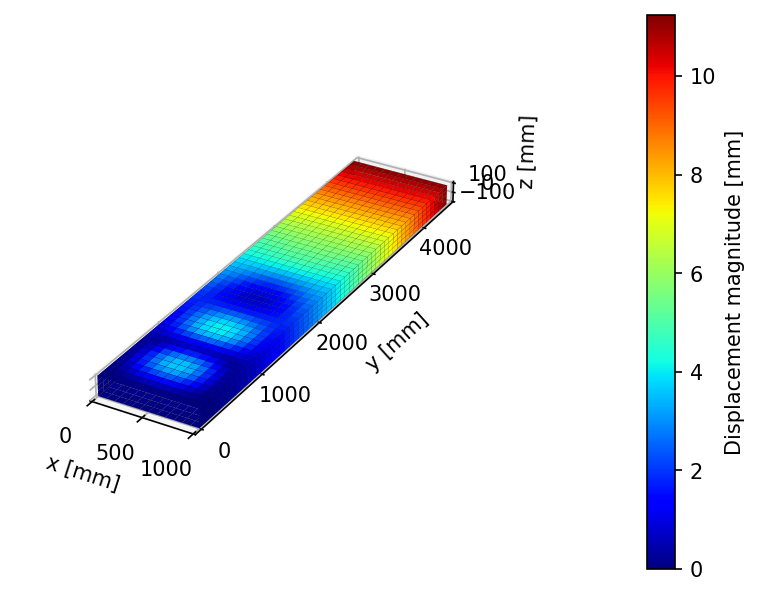

In [12]:
# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=op2_output)
# Plot SOL 106 buckling loads and critical buckling factors
plot_buckling_loads(load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
# Collect load and displacement history
load_history = np.concatenate([loads[subcase_id][:, load_component_index] for subcase_id in displacements])
displacement_history = np.concatenate([displacements[subcase_id][:,displacement_component_index] for subcase_id in displacements])
# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacement_history, load_history/linear_buckling_load, '.-')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()
# Plot structural deformation
valid_subcase_ids = [subcase_id for subcase_id in op2_output.load_vectors if hasattr(op2_output.load_vectors[subcase_id], 'lftsfqs')]
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=valid_subcase_ids[-1])
ax.locator_params(axis='x', nbins=3)  # number of x-axis ticks
ax.locator_params(axis='z', nbins=2)  # number of z-axis ticks
ax.tick_params(axis='y', which='major', pad=20)  # distance of y-axis tick labels
ax.tick_params(axis='z', which='major', pad=6)  # distance of z-axis tick labels
ax.yaxis.labelpad = 60  # distance of y-axis label
ax.zaxis.labelpad = 10  # distance of z-axis label
plt.show()

Let's apply twice the buckling load predicted by SOL 105 and monitor the definiteness of the tangent stiffness matrix.

In [13]:
box_beam_tangent_stiffness_matrix_input = box_beam_bdf_input.__deepcopy__({})
# Nonlinear analysis
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_tangent_stiffness_matrix_input, ninc=200, max_iter=25, conv='PUV', eps_p=1e-3, eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=2., desiter=2, maxinc=1000)
# Buckling parameters
box_beam_tangent_stiffness_matrix_input.add_param('BUCKLE', [2])
eigrl_set_id = force_set_id+1
box_beam_tangent_stiffness_matrix_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)
box_beam_tangent_stiffness_matrix_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)
# Force
box_beam_tangent_stiffness_matrix_input.loads[force_set_id][0].mag = linear_buckling_load*2
first_subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_tangent_stiffness_matrix_input, subcase_id=first_subcase_id, load_set_id=force_set_id)
# DMAP
box_beam_tangent_stiffness_matrix_input.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigv_nobuckle.dmap') + '\'']  # include DMAP sequence
# Define name of analysis directory
input_name = 'tangent_stiffness_matrix'
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_tangent_stiffness_matrix_input, filename=input_name, run_flag=False)

Nastran job tangent_stiffness_matrix.bdf completed
Wall time: 169.0 s


Plot results.

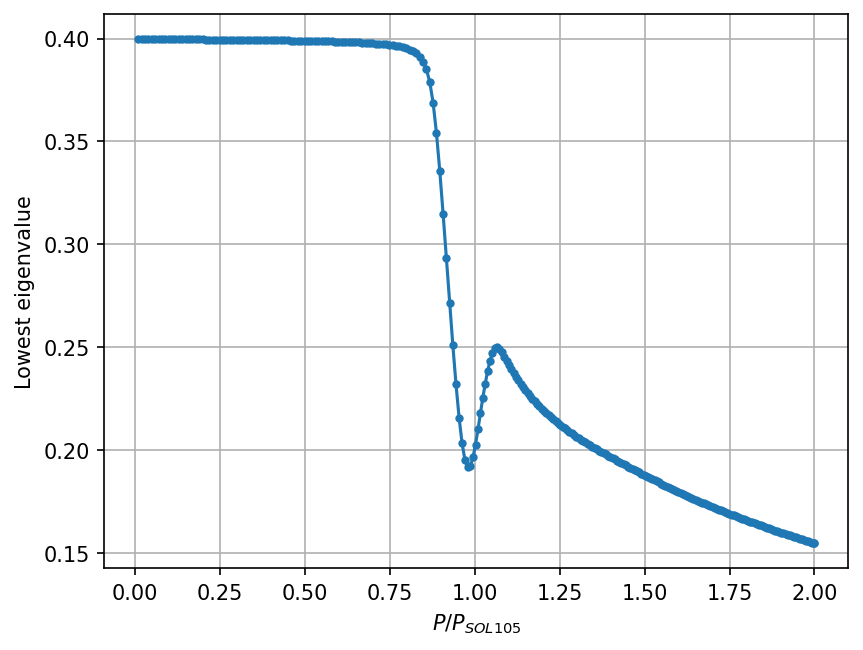

In [14]:
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False, load_geometry=True)
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
# Collect load and displacement history
load_history = np.concatenate([loads[subcase_id][:, load_component_index] for subcase_id in displacements])
displacement_history = np.concatenate([displacements[subcase_id][:,displacement_component_index] for subcase_id in displacements])
# Read the lowest eigenvalue of KLLRH matrices from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_name + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)
# Create new figure and plot load history vs lowest eigenvalues
_, ax = plt.subplots()
ax.plot(load_history/linear_buckling_load, lowest_eigenvalues, '.-')
plt.xlabel('$P/P_{SOL 105}$')
plt.ylabel('Lowest eigenvalue')
plt.grid()
plt.show()

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [15]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()